In [12]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
import os
import time


class LoggingCallback(BaseCallback):
    def __init__(self, log_dir="./logs", verbose=0):
        super(LoggingCallback, self).__init__(verbose)
        self.log_dir = log_dir
        self.log_file = None

    def _init_callback(self):
        # Create log directory if it doesn't exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Create log file
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        self.log_file = open(f"{self.log_dir}/training_log_{timestamp}.txt", "w")
        self.log_file.write("timestep,reward,explained_variance,value_loss,policy_loss\n")

    def _on_step(self):
        # Log at each step where training info is available
        if len(self.model.ep_info_buffer) > 0 and len(self.model.ep_info_buffer[-1]) > 0:
            ep_reward = self.model.ep_info_buffer[-1]["r"]

            # Get losses from logger
            explained_var = self.model.logger.name_to_value.get("train/explained_variance", 0)
            value_loss = self.model.logger.name_to_value.get("train/value_loss", 0)
            policy_loss = self.model.logger.name_to_value.get("train/policy_loss", 0)

            # Write to log file
            self.log_file.write(f"{self.num_timesteps},{ep_reward},{explained_var},{value_loss},{policy_loss}\n")
            self.log_file.flush()  # Ensure it's written immediately

        return True

    def _on_training_end(self):
        if self.log_file is not None:
            self.log_file.close()


class CustomHalfCheetahEnv(gym.Wrapper):

    def __init__(self):
        env = gym.make("HalfCheetah-v4")
        super().__init__(env)

    def step(self, action):
        observation, original_reward, terminated, truncated, info = self.env.step(action)
        reward = self.modified_reward_function(observation, action, original_reward)
        return observation, reward, terminated, truncated, info

    def modified_reward_function(self, observation, action, original_reward):

        # Forward velocity reward (using x-coordinate velocity, index 8)
        forward_reward = 0 * observation[8]

        # Penalize excessive vertical movement (z-coordinate, index 0)
        height_penalty = -0.05 * abs(observation[0] - 0.5)

        # Penalize excessive rotations for stability (angle of second rotor, index 2)
        rotation_penalty = -0.1 * abs(observation[2])

        # Energy efficiency - penalize excessive joint movements
        # Angular velocities from indices 10-16
        energy_penalty = -0.001 * sum(abs(observation[i]) for i in range(10, 17))

        # Smooth control - penalize large action changes
        control_penalty = -0.01 * np.sum(np.square(action))

        # Balance original reward with custom components
        original_reward_weight = 1

        # Combined reward
        reward = (
            forward_reward +
            height_penalty +
            rotation_penalty +
            energy_penalty +
            control_penalty +
            original_reward_weight * original_reward
        )

        return reward


# Create environment
env = CustomHalfCheetahEnv()

# Create model
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
)

# Create log directory
log_dir = "./logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Create callbacks
checkpoint_callback = CheckpointCallback(
    save_freq=100000,
    save_path=log_dir,
    name_prefix='ppo_halfcheetah'
)

# Create our custom logging callback
logging_callback = LoggingCallback(log_dir=log_dir)

# Combine callbacks
callbacks = [checkpoint_callback, logging_callback]

# Train model with callbacks
model.learn(total_timesteps=1000000, callback=callbacks)

print("Training completed!")

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.0423    |
|    std                  | 0.235      |
|    value_loss           | 11         |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 936         |
| time/                   |             |
|    fps                  | 467         |
|    iterations           | 263         |
|    time_elapsed         | 1151        |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.097731665 |
|    clip_fraction        | 0.555       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.283       |
|    explained_variance   | 0.742       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.14        |
|    n_updates            | 26

In [2]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [8]:
!pip install "gymnasium[mujoco]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 23.2 MB/s eta 0:00:00


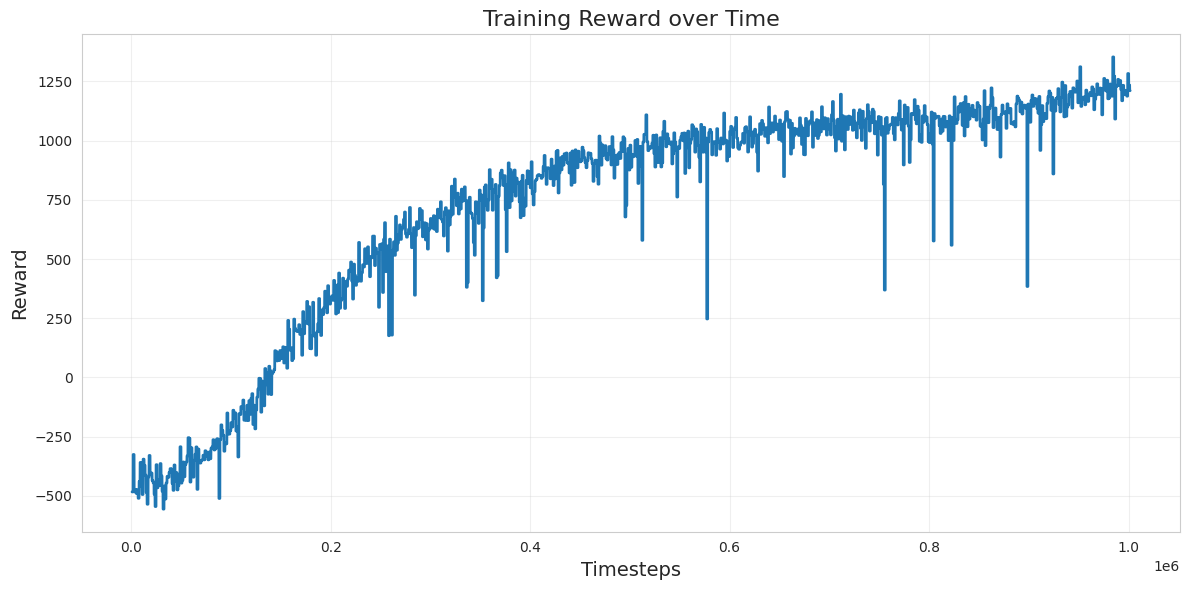

Plot saved as 'reward_plot.png'


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Read the data from the text file
def plot_training_data(log_file_path):
    # Read CSV file
    data = pd.read_csv(log_file_path)

    # Plot reward vs timestep
    plt.plot(data['timestep'], data['reward'], linewidth=2)

    # Add labels and title
    plt.xlabel('Timesteps', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.title('Training Reward over Time', fontsize=16)

    # Add grid and improve appearance
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the figure
    plt.savefig('reward_plot.png', dpi=300)

    # Show the plot
    plt.show()

    print(f"Plot saved as 'reward_plot.png'")

# Path to your log file
log_file_path = "/content/logs/training_log_20250411-024537.txt"  # Replace with your actual file path

# Generate the plot
plot_training_data(log_file_path)